In [11]:
import numpy as np
import pandas as pd

# 시뮬레이션을 위한 랜덤 데이터 생성
np.random.seed(42)

# 시간(t), 풍속, 구름양, 강수량, 날씨 좋음(라벨) 데이터 생성
data_size = 100  # 총 100개의 시간 데이터
time = np.arange(data_size) % 24  # 0~23 시간
wind_speed = np.random.randint(0, 11, data_size)  # 풍속 (0~10)
cloud_cover = np.random.randint(0, 3, data_size)  # 구름양 (0,1,2)
precipitation = np.random.randint(0, 11, data_size)  # 강수량 (0~10)

# 날씨 좋음(1) 또는 나쁨(0) 설정 (강수량이 2 이하이고 구름양이 1 이하이면 좋음)
weather_good = ((precipitation <= 2) & (cloud_cover <= 1)).astype(int)

# 데이터프레임 생성
df = pd.DataFrame({
    "Time": time,
    "WindSpeed": wind_speed,
    "CloudCover": cloud_cover,
    "Precipitation": precipitation,
    "WeatherGood": weather_good
})

print(df.head())  # 상위 5개 데이터 확인
print(df.shape)

# 3개 시간 스텝을 입력으로, 다음 시간의 날씨를 예측하도록 시퀀스 데이터 변환
sequence_length = 3  # RNN이 고려할 연속된 시간 길이

X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df.iloc[i:i+sequence_length, :-1].values)  # 마지막 열(WeatherGood) 제외
    y.append(df.iloc[i+sequence_length, -1])  # 다음 시간의 날씨 좋음 여부

X, y = np.array(X), np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")


   Time  WindSpeed  CloudCover  Precipitation  WeatherGood
0     0          6           1              4            0
1     1          3           2              0            0
2     2         10           1              7            0
3     3          7           0              0            1
4     4          4           2             10            0
(100, 5)
X shape: (97, 3, 4), y shape: (97,)


Epoch [10/300], Train Loss: 0.5051, Val Loss: 0.6699
Epoch [20/300], Train Loss: 0.4808, Val Loss: 0.6372
Epoch [30/300], Train Loss: 0.4545, Val Loss: 0.7028
Epoch [40/300], Train Loss: 0.4232, Val Loss: 0.7671
Epoch [50/300], Train Loss: 0.3789, Val Loss: 0.8275
Epoch [60/300], Train Loss: 0.3270, Val Loss: 0.9076
Epoch [70/300], Train Loss: 0.2763, Val Loss: 0.9855
Epoch [80/300], Train Loss: 0.2252, Val Loss: 1.0736
Epoch [90/300], Train Loss: 0.1677, Val Loss: 1.2523
Epoch [100/300], Train Loss: 0.1219, Val Loss: 1.3880
Epoch [110/300], Train Loss: 0.0888, Val Loss: 1.4822
Epoch [120/300], Train Loss: 0.0584, Val Loss: 1.5475
Epoch [130/300], Train Loss: 0.0350, Val Loss: 1.6594
Epoch [140/300], Train Loss: 0.0229, Val Loss: 1.7068
Epoch [150/300], Train Loss: 0.0170, Val Loss: 1.7249
Epoch [160/300], Train Loss: 0.0134, Val Loss: 1.7903
Epoch [170/300], Train Loss: 0.0110, Val Loss: 1.8425
Epoch [180/300], Train Loss: 0.0090, Val Loss: 1.8982
Epoch [190/300], Train Loss: 0.0072, 

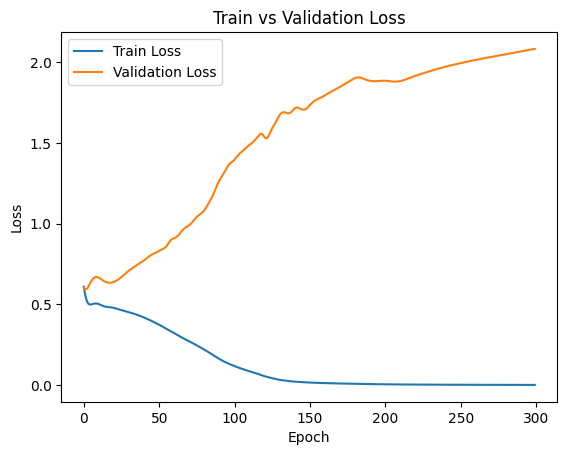

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# RNN 모델 정의
class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WeatherRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # 이진 분류를 위해 시그모이드 사용

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 초기 hidden state
        out, _ = self.rnn(x, h0)  # RNN 순전파
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝 출력만 사용
        return self.sigmoid(out)  # 확률값 출력

# 데이터셋 변환
sequence_length = 3
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df.iloc[i:i+sequence_length, :-1].values)  # 마지막 열(WeatherGood) 제외
    y.append(df.iloc[i+sequence_length, -1])  # 다음 시간의 날씨 예측

X, y = np.array(X), np.array(y)

# 훈련 / 검증 데이터 분할 (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch Tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (batch, 1) 형태로 변환
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# 모델 및 하이퍼파라미터 설정
input_size = 4  # 풍속, 구름양, 강수량, 시간
hidden_size = 16
num_layers = 1
output_size = 1  # 확률 값

model = WeatherRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # 이진 분류 → Binary Cross Entropy Loss 사용
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 과정 및 과적합 검증
num_epochs = 300
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# 학습된 모델 저장
torch.save(model.state_dict(), "weather_rnn.pth")
print("Model saved successfully!")

# 🔥 과적합 여부 확인 (Train Loss vs Validation Loss 그래프)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()


In [15]:
# 학습된 모델 불러오기
model.load_state_dict(torch.load("weather_rnn.pth"))
model.eval()

# 새로운 데이터 예측
new_data = np.array([
    [10, 2, 1, 0],  # (t-2)
    [8,  1, 0, 5],  # (t-1)
    [6,  0, 0, 10]  # (t)
])

new_data = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0)  # (1, 3, 4) 형태로 변환
predicted_prob = model(new_data).item()  # 확률 값 추출

print(f"Predicted Probability of Good Weather: {predicted_prob * 100:.2f}%")
print("Predicted Weather:", "Good" if predicted_prob > 0.5 else "Bad")


Predicted Probability of Good Weather: 3.51%
Predicted Weather: Bad
